In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from itertools import compress
from pylab import MaxNLocator
import seaborn as sns; sns.set()
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import ast
import itertools
import time
import sys
import itertools
import gzip

In [3]:
reference_genome_annotation = pd.read_csv('/home/rv76/Farhat_Lab/CSV_files/h37rv_genome_summary.txt', '\t').set_index('name')

####################################################################################################################################################################################

## [1] Collect *homoplasy count* from TopDis

####################################################################################################################################################################################

Load INDEL *mutant allele* annotation

In [4]:
INDEL_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape_indels/Genotypes_Filtered_2/genotypes_INDEL_functional_annotation.pkl')
INDEL_annotation_DF.loc[: , 'key'] = INDEL_annotation_DF.index
INDEL_annotation_DF.reset_index(inplace = True , drop = True)

In [5]:
INDEL_annotation_DF.head()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,key
0,313,ACCGACGAAG,A,Essential,dnaA,Rv0001,313,del,inframe,105,ACCGACGAAG_313_A
1,1549,TC,T,None,None,Rv0001_Rv0002,None,del,frameshift,None,TC_1549_T
2,1552,T,TAA,None,None,Rv0001_Rv0002,None,ins,frameshift,None,T_1552_TAA
3,1552,TAA,T,None,None,Rv0001_Rv0002,None,del,frameshift,None,TAA_1552_T
4,1552,T,TA,None,None,Rv0001_Rv0002,None,ins,frameshift,None,T_1552_TA


In [6]:
np.shape(INDEL_annotation_DF)

(47425, 11)

### Function to collect homoplasy count from TopDis ouput *homoplasy count* PKL files

In [7]:
def TopDis_homoplasy_count(global_lineage, spacer_length):
    
    #load mutation event count DF from Block Counting Method
    TopDis_homoplasy_count_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/homoplasies_detected_in_global_lineages/INDEL homoplasies/pickled dataframes/spacer_{0}/homoplasy_scores_lineage_{1}.pkl'.format(spacer_length, global_lineage))

    #drop unneccessary columns
    TopDis_homoplasy_count_DF = TopDis_homoplasy_count_DF.loc[: , ['key','homoplasy_score']]

    #set indel key (Ref Allele + Ref Pos + Alt Allele) as index
    TopDis_homoplasy_count_DF.set_index('key' , inplace = True , drop = True)

    #create a set of all minor alleles detected for this group of isolates
    unique_INDEL_i_mutant_alleles = set(TopDis_homoplasy_count_DF.index)

    #iterate through each mutant indel key and store homoplasy count
    homoplasy_count = []
    for INDEL_i in INDEL_annotation_DF.key:

        #check to see if INDEL_i mutant allele was detected within this isolate group/global lineage
        if INDEL_i in unique_INDEL_i_mutant_alleles:

            #homoplasy count that matches this INDEL position and mutant allele
            INDEL_i_mutant_allele_count = TopDis_homoplasy_count_DF.loc[INDEL_i , 'homoplasy_score']
            homoplasy_count.append(INDEL_i_mutant_allele_count)
            
        #particular SNP i - minor allele was not present within this group of isolates
        else:
            homoplasy_count.append(0)
        
    return homoplasy_count

### Collect homoplasy count from TopDis ouput for all global lineage (i.e. trees/isolate groups)

In [8]:
#there will be 6 different TopDis_homoplasy_DFs that corresponds to spacer lengths 1, 2, 3, 4, 5, 6
TopDis_homoplasy_DF_dict = {}
for spacer_length in ['1','2','3','4','5','6']:
    
    TopDis_homoplasy_DF = INDEL_annotation_DF.copy()

    for global_lineage in ['1' , '2' , '3' , '4A' , '4B' , '4C' , '5' , '6']:

        TopDis_homoplasy_DF.loc[: , global_lineage] = TopDis_homoplasy_count(global_lineage , spacer_length)

    #add homoplasy count across all lineages
    TopDis_homoplasy_DF.loc[: , 'total'] = TopDis_homoplasy_DF.loc[: , ['1' , '2' , '3' , '4A' , '4B' , '4C' , '5' , '6']].sum(axis = 1)
    
    #store DataFrame in dictionary for this spacer length - keys:space_length, values:TopDis homoplasy DFs
    TopDis_homoplasy_DF_dict[spacer_length] = TopDis_homoplasy_DF

In [9]:
TopDis_homoplasy_DF_dict['1'].head()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,key,1,2,3,4A,4B,4C,5,6,total
0,313,ACCGACGAAG,A,Essential,dnaA,Rv0001,313,del,inframe,105,ACCGACGAAG_313_A,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1549,TC,T,None,None,Rv0001_Rv0002,None,del,frameshift,None,TC_1549_T,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1552,T,TAA,None,None,Rv0001_Rv0002,None,ins,frameshift,None,T_1552_TAA,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1552,TAA,T,None,None,Rv0001_Rv0002,None,del,frameshift,None,TAA_1552_T,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1552,T,TA,None,None,Rv0001_Rv0002,None,ins,frameshift,None,T_1552_TA,3.0,0.0,1.0,5.0,1.0,1.0,0.0,0.0,11.0


In [10]:
np.shape(TopDis_homoplasy_DF_dict['1'])

(47425, 20)

In [11]:
TopDis_homoplasy_DF_dict['1'].sort_values(by = 'total' , ascending = False).head(n = 25)

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,key,1,2,3,4A,4B,4C,5,6,total
20085,1894300,G,GGTCTTGCCGC,Non-Essential,Rv1668c,Rv1668c,1043,ins,frameshift,348,G_1894300_GGTCTTGCCGC,542.0,1251.0,605.0,941.0,1100.0,668.0,16.0,11.0,5134.0
22757,2137521,A,ACTCCGATCAC,Non-Essential,Rv1888c,Rv1888c,559,ins,frameshift,187,A_2137521_ACTCCGATCAC,502.0,1086.0,636.0,960.0,1061.0,2.0,21.0,18.0,4286.0
14481,1313337,A,AG,None,None,Rv1179c_Rv1180,None,ins,frameshift,None,A_1313337_AG,434.0,929.0,593.0,853.0,761.0,638.0,0.0,20.0,4228.0
3014,234496,C,CGT,Non-Essential,Rv0197,Rv0197,2266,ins,frameshift,756,C_234496_CGT,303.0,881.0,403.0,681.0,746.0,543.0,18.0,21.0,3596.0
33901,3131469,T,TTGTCGGCGA,Antigen,Rv2823c,Rv2823c,305,ins,inframe,102,T_3131469_TTGTCGGCGA,273.0,879.0,266.0,654.0,716.0,156.0,9.0,7.0,2960.0
27292,2523205,G,GCGC,None,None,Rv2248_Rv2249c,None,ins,inframe,None,G_2523205_GCGC,260.0,791.0,352.0,507.0,611.0,413.0,8.0,7.0,2949.0
37879,3590686,G,GC,None,None,Rv3212_Rv3213c,None,ins,frameshift,None,G_3590686_GC,257.0,684.0,338.0,526.0,663.0,407.0,7.0,8.0,2890.0
39829,3794867,C,CCA,Non-Essential,dxs2,Rv3379c,1,ins,frameshift,1,C_3794867_CCA,557.0,1455.0,660.0,1.0,0.0,2.0,24.0,22.0,2721.0
35080,3296371,G,GCCGCGGC,Non-Essential,pks15,Rv2947c,1470,ins,frameshift,490,G_3296371_GCCGCGGC,501.0,1226.0,598.0,0.0,0.0,1.0,17.0,0.0,2343.0
11027,976897,T,TG,PE/PPE,PPE13,Rv0878c,1307,ins,frameshift,436,T_976897_TG,82.0,807.0,229.0,448.0,346.0,250.0,0.0,0.0,2162.0


####################################################################################################################################################################################

## [2] Compare *homoplasy count* from TopDis for different space lengths

####################################################################################################################################################################################

Compare *TopDis* Homoplasy Counts for each INDEL between Spacer Lengths: 1 & 2, 2 & 3, 3 & 4, 4 & 5

In [12]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

/home/rv76/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2117: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


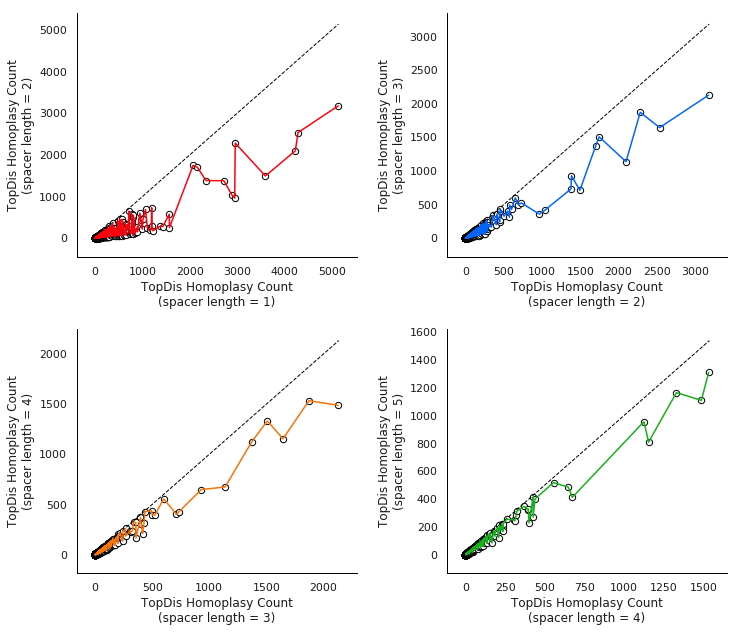

In [13]:
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
f_ax1 = fig.add_subplot(spec[0, 0])
f_ax2 = fig.add_subplot(spec[0, 1])
f_ax3 = fig.add_subplot(spec[1, 0])
f_ax4 = fig.add_subplot(spec[1, 1])

def plot_TopDis(n, color, ax):
    max_homoplasy_count = np.max([np.max(TopDis_homoplasy_DF_dict[str(n)].total) , np.max(TopDis_homoplasy_DF_dict[str(n+1)].total)])
    axis_pad = 5
    
    #plot y=x
    ax.plot([-axis_pad, max_homoplasy_count+axis_pad] , [-axis_pad, max_homoplasy_count+axis_pad] , color = '0.0' , linewidth = 1.0 , linestyle = '--' , alpha = 1.0)
    
    #sort the TopDis(n) homoplasy counts from smallest to largest
    TopDis_homoplasy_total_spacer_n_sorted = TopDis_homoplasy_DF_dict[str(n)].total.sort_values()
    TopDis_homoplasy_total_spacer_n_sorted_indices = TopDis_homoplasy_total_spacer_n_sorted.index
    #sort the TopDis(n+1) homoplasy counts according to the index of the sorted TopDis(n) homoplasy series
    TopDis_homoplasy_total_spacer_n_plus_1_sorted = TopDis_homoplasy_DF_dict[str(n+1)].total[TopDis_homoplasy_total_spacer_n_sorted_indices]
    ax.plot(TopDis_homoplasy_total_spacer_n_sorted , TopDis_homoplasy_total_spacer_n_plus_1_sorted , color = color , linewidth = 1.5 , linestyle = '-' , alpha = 1.0)
    ax.scatter(TopDis_homoplasy_total_spacer_n_sorted , TopDis_homoplasy_total_spacer_n_plus_1_sorted , color = '1.0' , linewidth = 1.0 , edgecolor = 'black', alpha = 1.0, s = 40)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(labelcolor = 'k')
    
    ax.set_xlabel('TopDis Homoplasy Count\n(spacer length = {0})'.format(str(n)) , fontsize = 12 , color = 'k')
    ax.set_ylabel('TopDis Homoplasy Count\n(spacer length = {0})'.format(str(n+1)) , fontsize = 12 , color = 'k')
    #ax.set_title('hSNP count between sampling in Subjects with Treatment Failure' , fontweight = 'bold', fontsize = 12 , color = 'k')
    
plot_TopDis(1, 'xkcd:bright red', f_ax1) #1 & 2
plot_TopDis(2, 'xkcd:bright blue', f_ax2) #2 & 3
plot_TopDis(3, 'xkcd:orange', f_ax3) #3 & 4
plot_TopDis(4, 'xkcd:green', f_ax4) #4 & 5

fig = plt.gcf()
fig.set_size_inches(10.5, 9.0)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/longitudinal_SNP_analysis/SNPs_detected_I2_vs_SNPs_detected_I1.pdf'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [14]:
TopDis_homoplasy_DF_dict['1'].sort_values(by = 'total' , ascending = False).head(n = 10)

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,key,1,2,3,4A,4B,4C,5,6,total
20085,1894300,G,GGTCTTGCCGC,Non-Essential,Rv1668c,Rv1668c,1043,ins,frameshift,348,G_1894300_GGTCTTGCCGC,542.0,1251.0,605.0,941.0,1100.0,668.0,16.0,11.0,5134.0
22757,2137521,A,ACTCCGATCAC,Non-Essential,Rv1888c,Rv1888c,559,ins,frameshift,187,A_2137521_ACTCCGATCAC,502.0,1086.0,636.0,960.0,1061.0,2.0,21.0,18.0,4286.0
14481,1313337,A,AG,None,None,Rv1179c_Rv1180,None,ins,frameshift,None,A_1313337_AG,434.0,929.0,593.0,853.0,761.0,638.0,0.0,20.0,4228.0
3014,234496,C,CGT,Non-Essential,Rv0197,Rv0197,2266,ins,frameshift,756,C_234496_CGT,303.0,881.0,403.0,681.0,746.0,543.0,18.0,21.0,3596.0
33901,3131469,T,TTGTCGGCGA,Antigen,Rv2823c,Rv2823c,305,ins,inframe,102,T_3131469_TTGTCGGCGA,273.0,879.0,266.0,654.0,716.0,156.0,9.0,7.0,2960.0
27292,2523205,G,GCGC,None,None,Rv2248_Rv2249c,None,ins,inframe,None,G_2523205_GCGC,260.0,791.0,352.0,507.0,611.0,413.0,8.0,7.0,2949.0
37879,3590686,G,GC,None,None,Rv3212_Rv3213c,None,ins,frameshift,None,G_3590686_GC,257.0,684.0,338.0,526.0,663.0,407.0,7.0,8.0,2890.0
39829,3794867,C,CCA,Non-Essential,dxs2,Rv3379c,1,ins,frameshift,1,C_3794867_CCA,557.0,1455.0,660.0,1.0,0.0,2.0,24.0,22.0,2721.0
35080,3296371,G,GCCGCGGC,Non-Essential,pks15,Rv2947c,1470,ins,frameshift,490,G_3296371_GCCGCGGC,501.0,1226.0,598.0,0.0,0.0,1.0,17.0,0.0,2343.0
11027,976897,T,TG,PE/PPE,PPE13,Rv0878c,1307,ins,frameshift,436,T_976897_TG,82.0,807.0,229.0,448.0,346.0,250.0,0.0,0.0,2162.0


In [15]:
TopDis_homoplasy_DF_dict['2'].sort_values(by = 'total' , ascending = False).head(n = 10)

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,key,1,2,3,4A,4B,4C,5,6,total
20085,1894300,G,GGTCTTGCCGC,Non-Essential,Rv1668c,Rv1668c,1043,ins,frameshift,348,G_1894300_GGTCTTGCCGC,327.0,686.0,420.0,593.0,688.0,440.0,15.0,9.0,3178.0
22757,2137521,A,ACTCCGATCAC,Non-Essential,Rv1888c,Rv1888c,559,ins,frameshift,187,A_2137521_ACTCCGATCAC,297.0,564.0,416.0,579.0,651.0,2.0,12.0,16.0,2537.0
33901,3131469,T,TTGTCGGCGA,Antigen,Rv2823c,Rv2823c,305,ins,inframe,102,T_3131469_TTGTCGGCGA,225.0,615.0,236.0,514.0,548.0,131.0,8.0,7.0,2284.0
14481,1313337,A,AG,None,None,Rv1179c_Rv1180,None,ins,frameshift,None,A_1313337_AG,207.0,468.0,287.0,437.0,380.0,313.0,0.0,6.0,2098.0
10886,968426,A,AGCCGGGTTG,PE/PPE,PE_PGRS15,Rv0872c,1819,ins,inframe,607,A_968426_AGCCGGGTTG,188.0,488.0,132.0,357.0,395.0,181.0,3.0,3.0,1747.0
11027,976897,T,TG,PE/PPE,PPE13,Rv0878c,1307,ins,frameshift,436,T_976897_TG,68.0,594.0,192.0,355.0,278.0,215.0,0.0,0.0,1702.0
3014,234496,C,CGT,Non-Essential,Rv0197,Rv0197,2266,ins,frameshift,756,C_234496_CGT,118.0,390.0,153.0,256.0,349.0,210.0,12.0,7.0,1495.0
35080,3296371,G,GCCGCGGC,Non-Essential,pks15,Rv2947c,1470,ins,frameshift,490,G_3296371_GCCGCGGC,297.0,665.0,409.0,0.0,0.0,1.0,13.0,0.0,1385.0
39829,3794867,C,CCA,Non-Essential,dxs2,Rv3379c,1,ins,frameshift,1,C_3794867_CCA,244.0,833.0,277.0,1.0,0.0,1.0,13.0,11.0,1380.0
37879,3590686,G,GC,None,None,Rv3212_Rv3213c,None,ins,frameshift,None,G_3590686_GC,99.0,257.0,103.0,179.0,262.0,135.0,2.0,1.0,1038.0


In [16]:
TopDis_homoplasy_DF_dict['3'].sort_values(by = 'total' , ascending = False).head(n = 10)

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,key,1,2,3,4A,4B,4C,5,6,total
20085,1894300,G,GGTCTTGCCGC,Non-Essential,Rv1668c,Rv1668c,1043,ins,frameshift,348,G_1894300_GGTCTTGCCGC,218.0,438.0,292.0,402.0,446.0,311.0,13.0,8.0,2128.0
33901,3131469,T,TTGTCGGCGA,Antigen,Rv2823c,Rv2823c,305,ins,inframe,102,T_3131469_TTGTCGGCGA,186.0,483.0,205.0,427.0,453.0,107.0,6.0,5.0,1872.0
22757,2137521,A,ACTCCGATCAC,Non-Essential,Rv1888c,Rv1888c,559,ins,frameshift,187,A_2137521_ACTCCGATCAC,190.0,382.0,272.0,363.0,418.0,1.0,9.0,10.0,1645.0
10886,968426,A,AGCCGGGTTG,PE/PPE,PE_PGRS15,Rv0872c,1819,ins,inframe,607,A_968426_AGCCGGGTTG,157.0,407.0,127.0,308.0,341.0,162.0,3.0,3.0,1508.0
11027,976897,T,TG,PE/PPE,PPE13,Rv0878c,1307,ins,frameshift,436,T_976897_TG,56.0,458.0,161.0,292.0,217.0,188.0,0.0,0.0,1372.0
14481,1313337,A,AG,None,None,Rv1179c_Rv1180,None,ins,frameshift,None,A_1313337_AG,103.0,279.0,139.0,231.0,209.0,175.0,0.0,2.0,1138.0
35080,3296371,G,GCCGCGGC,Non-Essential,pks15,Rv2947c,1470,ins,frameshift,490,G_3296371_GCCGCGGC,198.0,435.0,284.0,0.0,0.0,1.0,12.0,0.0,930.0
39829,3794867,C,CCA,Non-Essential,dxs2,Rv3379c,1,ins,frameshift,1,C_3794867_CCA,100.0,486.0,133.0,1.0,0.0,1.0,7.0,6.0,734.0
3014,234496,C,CGT,Non-Essential,Rv0197,Rv0197,2266,ins,frameshift,756,C_234496_CGT,64.0,190.0,60.0,107.0,187.0,93.0,10.0,2.0,713.0
11024,976897,T,TGG,PE/PPE,PPE13,Rv0878c,1307,ins,frameshift,436,T_976897_TGG,19.0,268.0,51.0,108.0,99.0,56.0,0.0,0.0,601.0


In [17]:
TopDis_homoplasy_DF_dict['4'].sort_values(by = 'total' , ascending = False).head(n = 10)

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,key,1,2,3,4A,4B,4C,5,6,total
33901,3131469,T,TTGTCGGCGA,Antigen,Rv2823c,Rv2823c,305,ins,inframe,102,T_3131469_TTGTCGGCGA,158.0,377.0,183.0,351.0,367.0,88.0,5.0,5.0,1534.0
20085,1894300,G,GGTCTTGCCGC,Non-Essential,Rv1668c,Rv1668c,1043,ins,frameshift,348,G_1894300_GGTCTTGCCGC,150.0,306.0,205.0,288.0,313.0,210.0,11.0,5.0,1488.0
10886,968426,A,AGCCGGGTTG,PE/PPE,PE_PGRS15,Rv0872c,1819,ins,inframe,607,A_968426_AGCCGGGTTG,138.0,345.0,118.0,275.0,302.0,147.0,3.0,3.0,1331.0
22757,2137521,A,ACTCCGATCAC,Non-Essential,Rv1888c,Rv1888c,559,ins,frameshift,187,A_2137521_ACTCCGATCAC,134.0,278.0,185.0,261.0,287.0,1.0,5.0,4.0,1155.0
11027,976897,T,TG,PE/PPE,PPE13,Rv0878c,1307,ins,frameshift,436,T_976897_TG,48.0,361.0,139.0,249.0,173.0,156.0,0.0,0.0,1126.0
14481,1313337,A,AG,None,None,Rv1179c_Rv1180,None,ins,frameshift,None,A_1313337_AG,56.0,195.0,65.0,129.0,124.0,104.0,0.0,1.0,674.0
35080,3296371,G,GCCGCGGC,Non-Essential,pks15,Rv2947c,1470,ins,frameshift,490,G_3296371_GCCGCGGC,129.0,313.0,197.0,0.0,0.0,1.0,9.0,0.0,649.0
11024,976897,T,TGG,PE/PPE,PPE13,Rv0878c,1307,ins,frameshift,436,T_976897_TGG,19.0,247.0,50.0,101.0,87.0,52.0,0.0,0.0,556.0
11021,976897,TG,T,PE/PPE,PPE13,Rv0878c,1307,del,frameshift,436,TG_976897_T,22.0,97.0,81.0,94.0,53.0,90.0,0.0,1.0,438.0
39829,3794867,C,CCA,Non-Essential,dxs2,Rv3379c,1,ins,frameshift,1,C_3794867_CCA,50.0,300.0,66.0,1.0,0.0,1.0,5.0,4.0,427.0


In [18]:
TopDis_homoplasy_DF_dict['5'].sort_values(by = 'total' , ascending = False).head(n = 10)

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,key,1,2,3,4A,4B,4C,5,6,total
33901,3131469,T,TTGTCGGCGA,Antigen,Rv2823c,Rv2823c,305,ins,inframe,102,T_3131469_TTGTCGGCGA,144.0,315.0,164.0,296.0,309.0,72.0,5.0,5.0,1310.0
10886,968426,A,AGCCGGGTTG,PE/PPE,PE_PGRS15,Rv0872c,1819,ins,inframe,607,A_968426_AGCCGGGTTG,117.0,295.0,109.0,239.0,262.0,137.0,3.0,3.0,1165.0
20085,1894300,G,GGTCTTGCCGC,Non-Essential,Rv1668c,Rv1668c,1043,ins,frameshift,348,G_1894300_GGTCTTGCCGC,97.0,237.0,154.0,215.0,240.0,153.0,9.0,4.0,1109.0
11027,976897,T,TG,PE/PPE,PPE13,Rv0878c,1307,ins,frameshift,436,T_976897_TG,46.0,293.0,122.0,217.0,135.0,143.0,0.0,0.0,956.0
22757,2137521,A,ACTCCGATCAC,Non-Essential,Rv1888c,Rv1888c,559,ins,frameshift,187,A_2137521_ACTCCGATCAC,96.0,213.0,116.0,182.0,194.0,1.0,4.0,3.0,809.0
11024,976897,T,TGG,PE/PPE,PPE13,Rv0878c,1307,ins,frameshift,436,T_976897_TGG,16.0,228.0,49.0,95.0,80.0,50.0,0.0,0.0,518.0
35080,3296371,G,GCCGCGGC,Non-Essential,pks15,Rv2947c,1470,ins,frameshift,490,G_3296371_GCCGCGGC,97.0,240.0,141.0,0.0,0.0,1.0,6.0,0.0,485.0
9614,854252,GCC,G,None,None,Rv0759c_Rv0760c,None,del,frameshift,None,GCC_854252_G,52.0,85.0,53.0,81.0,66.0,70.0,1.0,6.0,414.0
14481,1313337,A,AG,None,None,Rv1179c_Rv1180,None,ins,frameshift,None,A_1313337_AG,39.0,141.0,28.0,65.0,73.0,65.0,0.0,1.0,412.0
11021,976897,TG,T,PE/PPE,PPE13,Rv0878c,1307,del,frameshift,436,TG_976897_T,20.0,88.0,74.0,90.0,49.0,78.0,0.0,1.0,400.0


####################################################################################################################################################################################

## [3] Get *homoplasy count* from TopDis for *spacer length* = 4; prep for downstream analysis

####################################################################################################################################################################################

### [3.1] Load INDEL homoplasy count DataFrames

- INDEL homoplasy count is collected from counting *isolate blocks* with a specific indel (using binary genotypes matrix where each row indiciates a different INDEL)

In [19]:
all_homoplasic_INDELs = TopDis_homoplasy_DF_dict['4'].copy()

In [20]:
all_homoplasic_INDELs.head()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,key,1,2,3,4A,4B,4C,5,6,total
0,313,ACCGACGAAG,A,Essential,dnaA,Rv0001,313,del,inframe,105,ACCGACGAAG_313_A,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1549,TC,T,None,None,Rv0001_Rv0002,None,del,frameshift,None,TC_1549_T,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1552,T,TAA,None,None,Rv0001_Rv0002,None,ins,frameshift,None,T_1552_TAA,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1552,TAA,T,None,None,Rv0001_Rv0002,None,del,frameshift,None,TAA_1552_T,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1552,T,TA,None,None,Rv0001_Rv0002,None,ins,frameshift,None,T_1552_TA,3.0,0.0,1.0,4.0,1.0,1.0,0.0,0.0,10.0


In [21]:
np.shape(all_homoplasic_INDELs)

(47425, 20)

Filter out INDELs with less than 5 homoplasy events (DELETE)

In [22]:
## all_homoplasic_INDELs = all_homoplasic_INDELs[all_homoplasic_INDELs.total >= 5]

In [23]:
## np.shape(all_homoplasic_INDELs)

### [3.2] For each indel get better *gene names* from Mycobrowser annotation

Parse through Mycobrowser (tuberculist) to collect function & gene names

In [24]:
mycobrowser_table = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/complete_genomes/H37Rv/Mycobrowser_Release3/Mycobacterium_tuberculosis_H37Rv_txt_v3.txt' , sep = '\t')

#drop unnecessary columns
mycobrowser_table = mycobrowser_table.loc[: , ['Refseq_ID' , 'Feature' , 'Start' , 'Stop', 'Score' , 'Strand' , 'Frame' , 'Locus' , 'Name' , 'Function' , 'Product' , 'Comments' , 'UniProt_AC' , 'Is_Pseudogene' , 'Functional_Category']]

#organize by Start Ref Position
mycobrowser_table.sort_values(by = ['Start'] , inplace = True)

#reset index
mycobrowser_table.reset_index(inplace = True , drop = True)

#### Create mapping from *gene/intergenic* id to gene symbols/names

Get a list of genes/intergenic regions listed in df

In [25]:
gene_intergenic_region_IDs_list = list(set(all_homoplasic_INDELs.gene_id))
gene_intergenic_region_IDs_list = [x for x in gene_intergenic_region_IDs_list if str(x) != 'nan'] #remove nan values

In [26]:
len(gene_intergenic_region_IDs_list)

5419

Use mycobrowser table to get gene names/symbols for all gene/intergenic IDs

In [27]:
gene_names_list = []
for gene_intergenic_ID in gene_intergenic_region_IDs_list:
    
    if '_' not in gene_intergenic_ID:
        
        try:
            gene_names_list.append( mycobrowser_table[mycobrowser_table.Locus == gene_intergenic_ID].Name.values[0] )
        except IndexError:
            gene_names_list.append( gene_intergenic_ID )
        
    else:
        
        try:
            gene_name_1 = mycobrowser_table[mycobrowser_table.Locus == gene_intergenic_ID.split('_')[0]].Name.values[0]
        except IndexError:    
            gene_name_1 = gene_intergenic_ID.split('_')[0]
            
        try:
            gene_name_2 = mycobrowser_table[mycobrowser_table.Locus == gene_intergenic_ID.split('_')[1]].Name.values[0]
        except IndexError:    
            gene_name_2 = gene_intergenic_ID.split('_')[1]
        
        gene_names_list.append( gene_name_1 + '_' + gene_name_2 )

In [28]:
len(gene_names_list)

5419

Create dataframe for gene ids - gene names from Mycobrowser Annotation Table

In [29]:
gene_intergenic_region_ID_name_dict = dict([[gene_intergenic_id, gene_name] for gene_intergenic_id, gene_name in zip(gene_intergenic_region_IDs_list, gene_names_list)]) #convert to dictionary
gene_intergenic_region_ID_name_series = pd.Series(gene_intergenic_region_ID_name_dict, name = 'gene_name') #convert to series
gene_intergenic_region_ID_name_df = pd.DataFrame(gene_intergenic_region_ID_name_series) #convert to dataframe for merging
gene_intergenic_region_ID_name_df.loc[: , 'gene_id'] = gene_intergenic_region_ID_name_df.index #make gene_id a column
gene_intergenic_region_ID_name_df.reset_index(inplace = True , drop = True) #reset index

In [30]:
gene_intergenic_region_ID_name_df.head()

,gene_name,gene_id
0,dnaA,Rv0001
1,dnaA_dnaN,Rv0001_Rv0002
2,dnaN_recF,Rv0002_Rv0003
3,Rv0004_gyrB,Rv0004_Rv0005
4,gyrB,Rv0005


#### drop *gene name* column from original variant dataframe and merge with *gene name* dataframe created from mycobrowser annotation

In [31]:
all_homoplasic_INDELs.drop(['gene_name'] , axis = 1 , inplace = True)
all_homoplasic_INDELs = pd.merge(all_homoplasic_INDELs, gene_intergenic_region_ID_name_df, on = 'gene_id' , how = 'left')

In [32]:
all_homoplasic_INDELs.head()

,pos,ref,alt,gene_category,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,key,1,2,3,4A,4B,4C,5,6,total,gene_name
0,313,ACCGACGAAG,A,Essential,Rv0001,313,del,inframe,105,ACCGACGAAG_313_A,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,dnaA
1,1549,TC,T,None,Rv0001_Rv0002,None,del,frameshift,None,TC_1549_T,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,dnaA_dnaN
2,1552,T,TAA,None,Rv0001_Rv0002,None,ins,frameshift,None,T_1552_TAA,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,dnaA_dnaN
3,1552,TAA,T,None,Rv0001_Rv0002,None,del,frameshift,None,TAA_1552_T,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,dnaA_dnaN
4,1552,T,TA,None,Rv0001_Rv0002,None,ins,frameshift,None,T_1552_TA,3.0,0.0,1.0,4.0,1.0,1.0,0.0,0.0,10.0,dnaA_dnaN


In [33]:
np.shape(all_homoplasic_INDELs)

(47425, 20)

### [3.3] For each indel check whether the indel introduced a *premature stop codon* into the gene sequence

#### Get H37Rv locations for the non-coding RNA regions (to exclude from protein coding sequences)

In [39]:
#subset table to the non-coding RNA regions
mycobrowser_table_RNA = mycobrowser_table[[('RNA' in gene_feature) for gene_feature in mycobrowser_table.Feature]]

#subset table to protein coding regions
mycobrowser_table_CDS = mycobrowser_table[mycobrowser_table.Feature == 'CDS']
CDS_locus_tags = set(list(mycobrowser_table_CDS.Locus))

#get noncoding regions (H37Rv start/stop coordinates) as a list
RNA_regions = [[min(RNA_start , RNA_end) , max(RNA_start , RNA_end)] for RNA_start, RNA_end in zip(mycobrowser_table_RNA.Start, mycobrowser_table_RNA.Stop)]

def check_pos_in_RNA(ref_pos, locus_tag):
    '''
    This function checks to see if an H37Rv Reference Position 
    is located within an RNA region of the genome.
    
    First checks whether the H37Rv locus tag is protein coding
    CDS region. If not, then checks if located in an RNA region.
    
    Note - Reference Positions that are located in overlapping 
    CDS/RNA regions will by default be classified as belonging to 
    the CDS region.
    '''
    
    ref_pos_in_RNA = False #default to False (ref pos not in noncoding RNA region)
    
    #locus tag does not belong to CDS region, check if ref pos is located in RNA
    if locus_tag not in CDS_locus_tags:
    
        for RNA_region_i in RNA_regions:

            if (ref_pos >= RNA_region_i[0]) and (ref_pos <= RNA_region_i[1]):

                ref_pos_in_RNA = True
                break
                
    return ref_pos_in_RNA

#### Code to check whether an indel variant alters the stop codon

In [40]:
# Important Packages
################################################################################################################################################################################################
import os
import pandas as pd
import numpy as np
import sys
import pickle

import Bio
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import SeqIO
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
################################################################################################################################################################################################


# Relevant Information for H37Rv sequence functional annotation
################################################################################################################################################################################################
####### Collect all DNA and Amino Acid sequences corresponding to genes on H37Rv #######
#load reference genome and reference annotation
reference_genome = '/n/data1/hms/dbmi/farhat/bin/work-horse/bin/h37rv.fasta'
for reference_genome in SeqIO.parse(reference_genome, "fasta"):
    reference_genome.seq.alphabet = IUPAC.unambiguous_dna

reference_genome_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt', '\t').set_index('name')

####### Function to translate coding DNA sequences ####### 
def translate(gene_id, sequence):

    #find which strand the gene is located on and translate
    strand = reference_genome_annotation.loc[gene_id, 'strand']
    if strand == '+':
        protein_sequence = sequence.translate(table="Bacterial", cds=False)
    elif strand == '-':
        protein_sequence = sequence.reverse_complement().translate(table="Bacterial", cds=False)

    return protein_sequence

####### Load in dictionaries for SNP annotation #######
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/dicts_for_SNP_annotation/H37Rv_gene_seq_records.pickle', 'rb') as handle:
    ref_gene_sequences_records = pickle.load(handle)
    
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/dicts_for_SNP_annotation/H37Rv_protein_seq_records.pickle', 'rb') as handle:
    ref_protein_sequences_records = pickle.load(handle)
    
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/dicts_for_SNP_annotation/H37Rv_coord_gene_mapping.pickle', 'rb') as handle:
    ReferencePosition_Gene_mapping = pickle.load(handle)
    
####### get Gene Categories #######
gene_categories = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/gene_categories/gene_categories.csv').set_index('name')
gene_categories_dict = dict([gene_id , gene_category] for gene_id, gene_category in zip(list(gene_categories.gene_id) , list(gene_categories.Gene_Category)))

####### get Gene Symbols #######
gene_symbol_dict = dict([gene_id , gene_symbol] for gene_id, gene_symbol in zip(list(reference_genome_annotation.symbol.index) , list( reference_genome_annotation.symbol )))
################################################################################################################################################################################################

In [41]:
def check_stop_codon(ref_seq_position, indel_type, ref, alt, gene_intergenic_id):
    
    '''
    This function determines whether a given indel allele introduces a premature
    stop codon into the gene sequence, doesn't change the location of the stop codon, or 
    deletes the stop codon at the end (extending the AA seq).
    '''

    #check the reference position to make sure variant is not located in a non-coding RNA
    if check_pos_in_RNA(ref_seq_position, gene_intergenic_id) == True:
        premature_stop_codon = 'RNA'
        
    #check the locus id to make sure locus is not intergenic
    elif '_' in gene_intergenic_id:
        premature_stop_codon = 'intergenic'

    else:

        #find genomic coordinate of SNP relative to gene (subtract 1 since reference seq starts counting at 1)
        gene_relative_coord = int((ref_seq_position - 1) - min( reference_genome_annotation.loc[gene_intergenic_id , 'chromStart'] , reference_genome_annotation.loc[gene_intergenic_id , 'chromEnd'] ))

        #get sequence from dictionary of sequences (and convert to mutable object)
        test_gene_sequence = ref_gene_sequences_records[gene_intergenic_id].seq.tomutable()
        seq_before_indel = test_gene_sequence[0:gene_relative_coord]

        if indel_type == 'ins':

            #insertion allele
            seq_after_indel = test_gene_sequence[gene_relative_coord+1:]
            test_gene_sequence = seq_before_indel + alt + seq_after_indel

        elif indel_type == 'del':

            #deletion allele
            len_del = len(ref) - len(alt)
            seq_after_indel = test_gene_sequence[gene_relative_coord+1+len_del:]
            test_gene_sequence = seq_before_indel + alt + seq_after_indel

        #convert back immutable object
        test_gene_sequence = test_gene_sequence.toseq()

        #translate sequence into amino acid seq
        test_protein_sequence = translate(gene_intergenic_id , test_gene_sequence)

        #store the H37Rv AA seq to compare against
        H37Rv_AA_sequence = ref_protein_sequences_records[gene_intergenic_id].seq

        #compare to AA seq of original gene

        #one stop codon at the end of the gene does not truncate protein
        if (test_protein_sequence[-1] == '*') and (test_protein_sequence.count('*') == 1):

            premature_stop_codon = 'no change'

        #one stop codon not at the end of the gene OR multiple stop codons
        elif ((test_protein_sequence[-1] != '*') and (test_protein_sequence.count('*') == 1)) or (test_protein_sequence.count('*') > 1):

            #find index of first (or only) stop codon & length of gene
            first_stop_codon_i = float(test_protein_sequence.find('*') + 1.0)
            gene_length = float(len(test_protein_sequence))

            #calculate were stop is located relative to start codon
            stop_position = first_stop_codon_i / gene_length

            #annotate based on position of first stop codon
            if stop_position <= 0.75:
                premature_stop_codon = 'premature stop - first 3/4'

            elif stop_position > 0.75:
                premature_stop_codon = 'premature stop - last 1/4'

        #no stop codons
        elif (test_protein_sequence.count('*') == 0):

            premature_stop_codon = 'elongation - appears after annotated stop'

    return premature_stop_codon

In [42]:
all_homoplasic_INDELs.head()

,pos,ref,alt,gene_category,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,key,1,2,3,4A,4B,4C,5,6,total,gene_name
0,313,ACCGACGAAG,A,Essential,Rv0001,313,del,inframe,105,ACCGACGAAG_313_A,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,dnaA
1,1549,TC,T,None,Rv0001_Rv0002,None,del,frameshift,None,TC_1549_T,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,dnaA_dnaN
2,1552,T,TAA,None,Rv0001_Rv0002,None,ins,frameshift,None,T_1552_TAA,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,dnaA_dnaN
3,1552,TAA,T,None,Rv0001_Rv0002,None,del,frameshift,None,TAA_1552_T,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,dnaA_dnaN
4,1552,T,TA,None,Rv0001_Rv0002,None,ins,frameshift,None,T_1552_TA,3.0,0.0,1.0,4.0,1.0,1.0,0.0,0.0,10.0,dnaA_dnaN


#### Iterate through each indel allele and check to see if *premature stop codon* is introduced into gene sequence by variant

In [43]:
stop_codon_list = []

for ref_pos, indel_type, ref, alt, gene_id in zip(all_homoplasic_INDELs.pos, all_homoplasic_INDELs.ins_del, all_homoplasic_INDELs.ref, all_homoplasic_INDELs.alt, all_homoplasic_INDELs.gene_id):

    stop_codon_list.append(check_stop_codon(ref_pos, indel_type, ref, alt, gene_id))

#append column to dataframe
all_homoplasic_INDELs.loc[: , 'stop_codon'] = stop_codon_list

/home/rv76/anaconda2/lib/python2.7/site-packages/Bio/Seq.py:2715: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


In [44]:
all_homoplasic_INDELs.head()

,pos,ref,alt,gene_category,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,key,...,2,3,4A,4B,4C,5,6,total,gene_name,stop_codon
0,313,ACCGACGAAG,A,Essential,Rv0001,313,del,inframe,105,ACCGACGAAG_313_A,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,dnaA,no change
1,1549,TC,T,None,Rv0001_Rv0002,None,del,frameshift,None,TC_1549_T,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,dnaA_dnaN,intergenic
2,1552,T,TAA,None,Rv0001_Rv0002,None,ins,frameshift,None,T_1552_TAA,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,dnaA_dnaN,intergenic
3,1552,TAA,T,None,Rv0001_Rv0002,None,del,frameshift,None,TAA_1552_T,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,dnaA_dnaN,intergenic
4,1552,T,TA,None,Rv0001_Rv0002,None,ins,frameshift,None,T_1552_TA,...,0.0,1.0,4.0,1.0,1.0,0.0,0.0,10.0,dnaA_dnaN,intergenic


### [3.4] For each indel find the number of isolates (N = 31,428) *and* store the isolate IDs that support the indel call

#### Load INDEL genotype matrix and Annotation Files

In [45]:
#load isolate annotation file (columns of Genotype Matrix)
isolate_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape_indels/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl')

#load INDEL annotation file (rows of Genotype Matrix) with gene annotation information
INDEL_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape_indels/Genotypes_Filtered_2/genotypes_INDEL_annotation.pkl')

#load Genotypes Matrix
genotypes_array =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape_indels/Genotypes_Filtered_2/genotypes_matrix.npy')

In [46]:
isolate_annotation_DF.head()

,isolate_ID,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,lineage_call,group
0,SAMN13051687,2,2,1,1,1,i3,NaN,NaN,NaN,NaN,NaN,2.2.1.1.1.i3,2
1,SAMN09100245,4,2,1,2,1,1,i3,2,NaN,NaN,NaN,4.2.1.2.1.1.i3.2,4B
2,SAMN08732238,2,2,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,2.2.1.1.1,2
3,SAMN07658260,3,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.1.1,3
4,SAMN03648003,2,2,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,2.2.1.1.1,2


In [47]:
np.shape(isolate_annotation_DF)

(31428, 14)

In [48]:
INDEL_annotation_DF.head()

,key,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
0,ACCGACGAAG_313_A,313,ACCGACGAAG,A,Rv0001,312.0,Essential,dnaA
1,TC_1549_T,1549,TC,T,intergenic,NaN,None,None
2,T_1552_TAA,1552,T,TAA,intergenic,NaN,None,None
3,TAA_1552_T,1552,TAA,T,intergenic,NaN,None,None
4,T_1552_TA,1552,T,TA,intergenic,NaN,None,None


In [49]:
np.shape(INDEL_annotation_DF)

(47425, 8)

In [50]:
np.shape(genotypes_array)

(47425, 31428)

#### calculate the proportion of singletons

count the number of isolates that harbor each INDEL

In [51]:
genotypes_matrix_alternate_alleles_count = np.sum( genotypes_array == 1 , axis = 1 ) # alternate allele

In [52]:
genotypes_matrix_alternate_alleles_count

array([3, 3, 3, ..., 1, 3, 1])

In [53]:
len(genotypes_matrix_alternate_alleles_count)

47425

number of INDELs that were detected in just 1 isolate

In [54]:
sum(genotypes_matrix_alternate_alleles_count == 1)

27937

proportion of singletons

In [55]:
float(sum(genotypes_matrix_alternate_alleles_count == 1)) / float(len(genotypes_matrix_alternate_alleles_count))

0.5890774907749078

#### calculate the number of isolates that harbor each INDEL allele

In [56]:
num_isolates_with_INDEL_i_list = []
isolate_IDs_with_INDEL_i_list = []

for INDEL_i in all_homoplasic_INDELs.key:

    #Get Genotypes for INDEL
    #get row index of genotypes matrix that corresponds to this row
    INDEL_i_row_index = INDEL_annotation_DF[INDEL_annotation_DF.key == INDEL_i].index.values[0]

    #get the genotypes for all isolates
    INDEL_i_genotypes = genotypes_array[INDEL_i_row_index , :]

    #construct a boolean array that is TRUE if isolate's genotype support the INDEL allele and FALSE otherwise
    isolate_mutant_allele_match_bool = INDEL_i_genotypes == 1
    
    num_isolates_with_INDEL_i_list.append(np.sum(isolate_mutant_allele_match_bool))
    
    #use the boolean area to get a list of isolate IDs that support the INDEL allele
    isolate_IDs_with_INDEL_i_list.append(list(isolate_annotation_DF[isolate_mutant_allele_match_bool].isolate_ID))
    
#append as columns in the Homoplasic INDEL DataFrame
all_homoplasic_INDELs.loc[: , 'num_isolates'] = num_isolates_with_INDEL_i_list

#convert list of lists to list of strings for isolates IDs (seperated by '/')
isolate_IDs_with_INDEL_i_strings = ['/'.join(isolate_IDs_list) for isolate_IDs_list in isolate_IDs_with_INDEL_i_list]
all_homoplasic_INDELs.loc[: , 'isolates_with_indel'] = isolate_IDs_with_INDEL_i_strings

In [57]:
all_homoplasic_INDELs.head()

,pos,ref,alt,gene_category,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,key,...,4A,4B,4C,5,6,total,gene_name,stop_codon,num_isolates,isolates_with_indel
0,313,ACCGACGAAG,A,Essential,Rv0001,313,del,inframe,105,ACCGACGAAG_313_A,...,0.0,1.0,0.0,0.0,0.0,1.0,dnaA,no change,3,SAMN08215445/SAMN08214873/SAMN08214857
1,1549,TC,T,None,Rv0001_Rv0002,None,del,frameshift,None,TC_1549_T,...,1.0,0.0,0.0,0.0,0.0,1.0,dnaA_dnaN,intergenic,3,SAMEA3374747/SAMEA104362125/SAMEA5569546
2,1552,T,TAA,None,Rv0001_Rv0002,None,ins,frameshift,None,T_1552_TAA,...,0.0,1.0,0.0,0.0,0.0,1.0,dnaA_dnaN,intergenic,3,SAMEA1118881/SAMN09100567/SAMN09099629
3,1552,TAA,T,None,Rv0001_Rv0002,None,del,frameshift,None,TAA_1552_T,...,0.0,0.0,1.0,0.0,0.0,1.0,dnaA_dnaN,intergenic,1,SAMEA1102755
4,1552,T,TA,None,Rv0001_Rv0002,None,ins,frameshift,None,T_1552_TA,...,4.0,1.0,1.0,0.0,0.0,10.0,dnaA_dnaN,intergenic,19,SAMN08794962/SAMN08628996/SAMEA104394551/SAMN0...


In [58]:
np.shape(all_homoplasic_INDELs)

(47425, 23)

### [3.5] output INDEL homoplasy count as CSV & PKL

Drop mutations with a homoplasy score = 0

In [59]:
all_homoplasic_INDELs_output = all_homoplasic_INDELs[all_homoplasic_INDELs.total > 0]

In [60]:
np.shape(all_homoplasic_INDELs_output)

(46306, 23)

In [61]:
all_homoplasic_INDELs_output.sort_values(by = ['gene_category', 'total'] , ascending = [True, False] , inplace = True)

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [62]:
all_homoplasic_INDELs_output.head()

,pos,ref,alt,gene_category,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,key,...,4A,4B,4C,5,6,total,gene_name,stop_codon,num_isolates,isolates_with_indel
47371,4408100,GC,G,Antibiotic Resistance,Rv3919c,103,del,frameshift,35,GC_4408100_G,...,43.0,11.0,29.0,0.0,0.0,202.0,gid,premature stop - first 3/4,388,SAMEA1019088/SAMN07236495/SAMN04396845/SAMN060...
47365,4408087,CG,C,Antibiotic Resistance,Rv3919c,116,del,frameshift,39,CG_4408087_C,...,33.0,10.0,18.0,0.0,0.0,130.0,gid,premature stop - first 3/4,212,SAMN06055937/SAMEA1119059/SAMEA104304858/TDR14...
47313,4407851,GC,G,Antibiotic Resistance,Rv3919c,352,del,frameshift,118,GC_4407851_G,...,20.0,6.0,19.0,0.0,0.0,115.0,gid,premature stop - first 3/4,182,SAMN07344649/SAMN09101323/Peru4135/SAMEA342116...
25151,2288850,A,ACC,Antibiotic Resistance,Rv2043c,392,ins,frameshift,131,A_2288850_ACC,...,3.0,6.0,2.0,0.0,0.0,32.0,pncA,premature stop - last 1/4,48,SAMN02419582/SAMN09399440/SAMN02231166/SAMN083...
47315,4407851,G,GC,Antibiotic Resistance,Rv3919c,352,ins,frameshift,118,G_4407851_GC,...,5.0,7.0,1.0,0.0,0.0,31.0,gid,premature stop - last 1/4,52,SAMN03648534/IDR1500000665/M0000827-7/SAMEA317...


In [63]:
all_homoplasic_INDELs_output.tail()

,pos,ref,alt,gene_category,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,key,...,4A,4B,4C,5,6,total,gene_name,stop_codon,num_isolates,isolates_with_indel
46698,4375788,T,TG,PE/PPE,Rv3893c,208,ins,frameshift,70,T_4375788_TG,...,1.0,0.0,0.0,0.0,0.0,1.0,PE36,elongation - appears after annotated stop,392,SAMN09099729/SAMN05577589/SAMEA5282520/SAMEA10...
46699,4375794,GT,G,PE/PPE,Rv3893c,202,del,frameshift,68,GT_4375794_G,...,0.0,0.0,0.0,0.0,0.0,1.0,PE36,elongation - appears after annotated stop,1,SAMEA5542046
46700,4375898,GGC,G,PE/PPE,Rv3893c,98,del,frameshift,33,GGC_4375898_G,...,1.0,0.0,0.0,0.0,0.0,1.0,PE36,premature stop - first 3/4,3,SAMEA3139846/SAMEA3558136/SAMEA1877167
46701,4375911,C,CG,PE/PPE,Rv3893c,85,ins,frameshift,29,C_4375911_CG,...,0.0,0.0,0.0,0.0,0.0,1.0,PE36,premature stop - first 3/4,1,SAMD00117897
46702,4375988,CA,C,PE/PPE,Rv3893c,8,del,frameshift,3,CA_4375988_C,...,1.0,0.0,0.0,0.0,0.0,1.0,PE36,elongation - appears after annotated stop,8,SAMN09101598/SAMN09100452/SAMEA1397473/SAMEA19...


In [64]:
np.shape(all_homoplasic_INDELs_output)

(46306, 23)

Save as a CSV file & PKL file

In [65]:
all_homoplasic_INDELs_output.loc[: , ['pos','ref','alt','gene_category','gene_name','gene_id','gene_pos','ins_del','INDEL_type','codon_pos','stop_codon','key','1','2','3','4A','4B','4C','5','6','total','num_isolates']].to_csv('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/homoplasies_detected_in_global_lineages/INDEL homoplasies/homoplasy_count_across_lineages_spacer_4.csv')
all_homoplasic_INDELs_output.loc[: , ['pos','ref','alt','gene_category','gene_name','gene_id','gene_pos','ins_del','INDEL_type','codon_pos','stop_codon','key','1','2','3','4A','4B','4C','5','6','total','num_isolates']].to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/homoplasies_detected_in_global_lineages/INDEL homoplasies/homoplasy_count_across_lineages_spacer_4.pkl')